# Sentiment Analysis: Recensioni Amazon

Autore: Alessandro Piccione

Matricola: 0365631

Traccia progetto: T1e

#Introduzione
L'obiettivo di questo progetto è realizzare un modello di Machine Learning che assolva al task di sentiment analysis su una serie di recensioni amazon. In poche parole dovremo realizzare un modello in grado di effettuare una classificazione binaria di recensioni amazon. A nostra disposizione abbiamo un dataset di recensioni Amazon etichettato (Tools_and_Home_ImprovementBinary) che verrà utilizzato per addestrare e fare una validazione del modello.
Nel corso di questo documento vedremo una serie di modelli che adempiono allo stesso task e ne confronteremo l'efficienza in termini di computazionalità ed accuratezza, mettendoli a confronto tra di loro.

##Modelli affrontati

I modelli che prenderò in considerazione per affrontare il task sono:
- Naive Bayes: un modello semplice ed efficiente per la classificazione di testi. La sua semplicità mi permette di utilizzarlo come modello di partenza da mettere a confronto con il modello finale.

- RNN: la maggior parte del focus ricade nella progettazione di una Recurrent Neural Network. Ho voluto scegliere questa tipologia di rete neurale poiché si comporta molto bene nell'elaborazione di dati sequenziali, tra cui anche i testi. Anche se ad oggi per task legati al NLP (Natural Language Process) abbiamo i Transformers che sono risultati essere la tecnologia rivoluzionaria nel campo del machine learning che ha superato i limiti delle Reti Neurali Ricorrenti, nel corso di questo progetto ho voluto optare alla realizzazione di una RNN poiché più facilmente addestrabile con la quantità di risorse a disposizione. Per utilizzare dei transformers avrei potuto optare anche all'utilizzo di modelli pre addestrati, limitando la capacità decisionale sull'architettura della nostra rete. Ai fini del progetto preferisco avere piena capacità decisionale per poter sperimentare con l'architettura.




#Setup dell'environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras-tuner

In [4]:
!unzip drive/MyDrive/Tools_and_Home_ImprovementBinary.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: Tools_and_Home_ImprovementBinary/1/18825.txt  
 extracting: Tools_and_Home_ImprovementBinary/1/3939.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/17531.txt  
 extracting: Tools_and_Home_ImprovementBinary/1/15964.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/1565.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/1670.txt  
 extracting: Tools_and_Home_ImprovementBinary/1/16216.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/9876.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/11902.txt  
 extracting: Tools_and_Home_ImprovementBinary/1/6287.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/7722.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/13123.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/9022.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/15052.txt  
 extracting: Tools_and_Home_ImprovementBinary/1/17738.txt  
  inflating: Tools_and_Home_ImprovementBinary/1/6987.txt 

#Definizione delle dipendenze

In [23]:
#Standard dependencies
import os
import re
import math
import pickle as pkl

#Data processing dependencies
import pandas as pd
import numpy as np

#ML dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import naive_bayes,pipeline
from tensorflow.keras import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#visualization dependencies
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#Definizione delle funzioni di base

Nel corso di questa sezione definisco alcune funzioni di base riutilizzabili all'interno del notebook

In [56]:
#Function that unbatch the batched dataset
def datasetUnbatch(batchedDs):
  xData = []
  yData = []
  for x,y in batchedDs.unbatch():
    xData.append(x.numpy().decode()) #we convert the data from a tensor to a python string
    yData.append(y.numpy())
  return xData, yData

#Function that return dataframes from the dataset
def datasetToDataFrame(dataset):
  data = []
  labels = []
  for text,label in dataset.unbatch():
    data.append(text.numpy().decode())
    if label.numpy() == 1:
      labels.append('Positive')
    else:
      labels.append('Negative')
  return pd.DataFrame({'text': data, 'label': labels})

#Some functions that i will use for analysis of the data

def plotSentimentDistribution(df):
  sentimentCounts = df['label'].value_counts()
  plt.pie(sentimentCounts, labels=sentimentCounts.index, autopct='%1.1f%%',colors=["lightcoral","lightgreen"],startangle=90)
  plt.title("Sentiment Distribution")
  plt.show()

def plotWordFrequency(df, target, top_n=10):
  reviews = df[df['label'] == target]["text"]
  vectorizer = CountVectorizer(stop_words='english')
  word_counts = vectorizer.fit_transform(reviews).sum(axis=0).A1
  words = vectorizer.get_feature_names_out()

  word_freq = pd.DataFrame({'word': words, 'frequency': word_counts})
  word_freq = word_freq.sort_values(by='frequency', ascending=False).head(top_n)

  plt.figure(figsize=(5, 3))
  plt.bar(word_freq['word'], word_freq['frequency'], color='tab:blue', label=target)
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title(f'Top {top_n} Most Frequent Words in {target} reviews')
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()


def plotReviewsLengthDistribution(df,max):
  df['length'] = df['text'].apply(lambda x: len(x.split()))
  density = gaussian_kde(df['length'])
  x_values = np.linspace(df['length'].min(), max, 1000)
  density_values = density(x_values)
  plt.plot(x_values, density_values, color='tab:orange')
  plt.title('Review Length Distribution')
  plt.xlabel('Review Length')
  plt.ylabel('Density')
  plt.show()

def evaluateMetrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  results = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Value': [accuracy, precision, recall, f1]
  })

  return results

def plot_training_history(history):
    # Estrai i dati dalla storia
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creazione della figura con due subplot
    plt.figure(figsize=(12, 5))

    # Plot dell'accuratezza
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot della loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Mostra il plot
    plt.tight_layout()
    plt.show()



#Caricamento del dataset

In questa fase ci occupiamo di definire una funzione utile al caricamento del dataset e la utiliziamo per adempiere all'obiettivo. Di seguito vengono stampate le quantità di dati presenti nel training, validation e test set

In [7]:
data_dir = 'Tools_and_Home_ImprovementBinary'

def loadDataset(data_dit, batch_size=32, validation=0.2, test=0.1, seed=42):
  train_ds = tf.keras.preprocessing.text_dataset_from_directory(
      data_dir,
      batch_size=batch_size,
      validation_split=validation+test,
      subset='training',
      seed=seed)
  val_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
      data_dir,
      batch_size=batch_size,
      validation_split=validation+test,
      subset='validation',
      seed=seed)

  val_size = math.floor((validation / (validation + test)) * len(val_test_ds))

  val_ds = val_test_ds.take(val_size)
  test_ds = val_test_ds.skip(val_size)

  print("Training set size:", len(train_ds)*batch_size)
  print("Validation set size:", len(val_ds)*batch_size)
  print("Test set size:", len(test_ds)*batch_size)

  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = loadDataset(data_dir)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Found 40000 files belonging to 2 classes.
Using 12000 files for validation.
Training set size: 28000
Validation set size: 8000
Test set size: 4000


Utilizziamo la funzione datasetToDataFrame inizialmente implementata per traformare il dataset nella forma {text: '...' , sentiment:'...'} che ci sarà utile per condurre delle analisi sui dati.

In [8]:
train_df = datasetToDataFrame(train_ds)
val_df = datasetToDataFrame(val_ds)
test_df = datasetToDataFrame(test_ds)

df = pd.concat([train_df, val_df, test_df])

# Analisi dei dati

Di seguito viene svolta un'analisi dei dati andando a studiare:
  - **La distibuzione dei sentimenti**: vediamo quante sono le recensioni del dataset negative e quante sono le recensioni positive
  -**La frequenza delle parole nelle recensioni positive/negative**: ciò ci aiuterà a comprendere quali sono quelle parole che si ripetono più volte
  -**Distibuzione della lunghezza**: vogliamo studiare in media quante parole contiene una recensione

##Distribuzione dei sentimenti

Per effettuare questo passo dell'analisi fornisco un grafico a torta che ci fa notare una buona distribuzione dei sentimenti. Di fatto l'intero dataset è perfettamente bilanciato con il 50% delle recensioni positive ed il 50% delle recensioni negative

##Word Frequency

Qui vengono proposti due istiogrammi uno per le recensioni positive ed uno per le recensioni negative. Sull' asse delle ascisse sono disposte le prime 10 parole che si sono distinte per frequenza mentre sull'asse delle ordinate ci viene data la quantità di volte in cui quella parola si è ripetuta all'interno delle recensioni.

##Distibuzione della lunghezza

Per questa fase viene proposto un grafico che presenta sull'asse X la lunghezza delle recensioni misurata in numero di parole. Mentre sull'asse Y viene rappresentata la densità di probabilità della lunghezza delle recensioni. In altre parole l'asse Y indica quanto è probabile trovare una recensione con una determinata lunghezza. Un valore più alto di densità indica che ci sono più recensioni con quella lunghezza



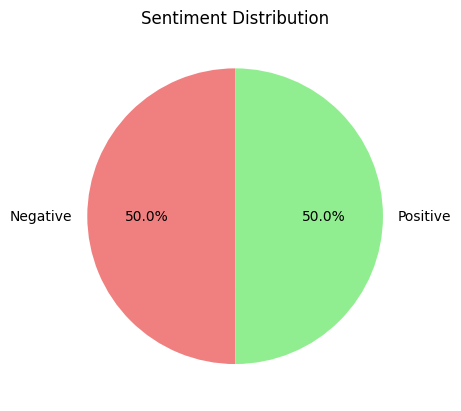

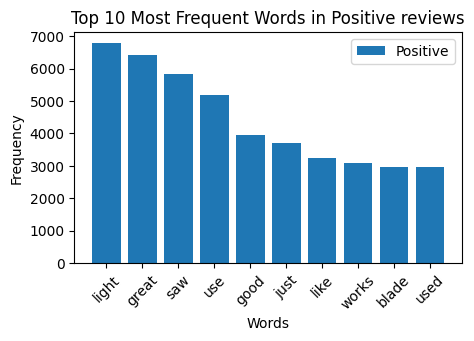

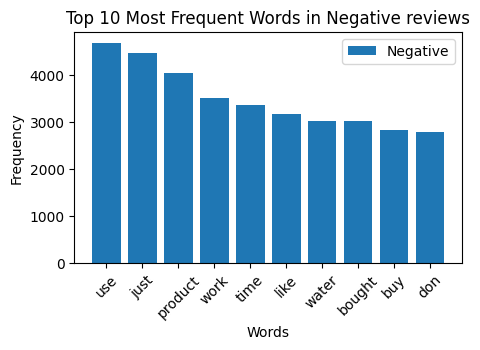

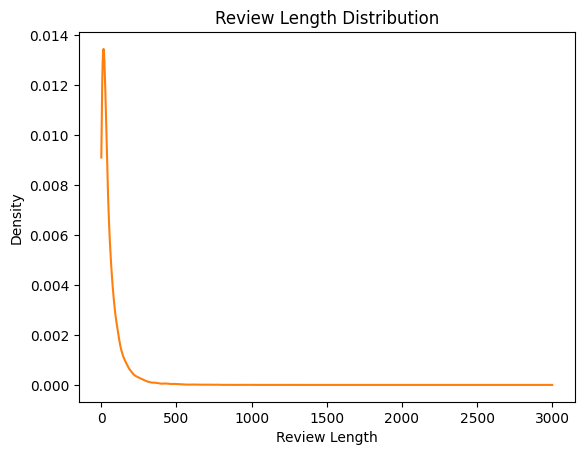

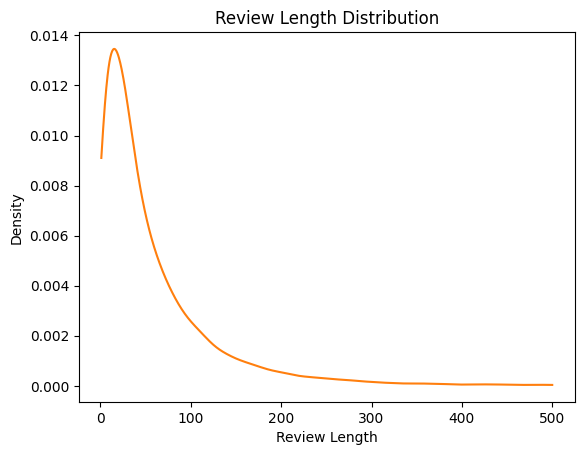

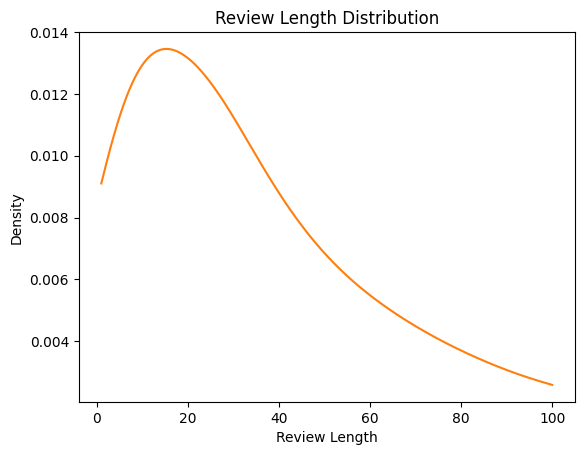

In [9]:
#Sentiment distribution
plotSentimentDistribution(df)
#Word Frequency
plotWordFrequency(df,"Positive")
plotWordFrequency(df,"Negative")
#Length distribution
plotReviewsLengthDistribution(df,3000)
plotReviewsLengthDistribution(df,500)
plotReviewsLengthDistribution(df,100)

#Preprocessing e vettorizzazione

Nell'ambito di questa sezione verranno definite alcune funzioni utili a:

- **preprocessare i dati**: andremo a definire delle funzioni che trasformeranno i nostri dati originali in una forma più compatta. Ciò verrà fatto andando a rimuovere dalle recensioni caratteri speciali, punteggiature e spazi presenti all'inizio ed alla fine dei testi. Inoltre verrà messa la possibilità di rimuovere le stopwords. Questa fase è molto importante e permetterà di velocizzare in modo notevole la velocità di training sui nostri modelli di ML

- **vettorizzazione**: verranno definite delle funzioni utili a trasformare i nostri dati originali in vettori a numeri reali. Per fare ciò dovremo definire una strategia per la tokenizzazione e definire delle funzioni che aggiungano un layer di embedding alla rete. Nell'ambito del progetto ho deciso di utilizzare un layer di embedding pre addestrato per velocizzare l'addestramento.

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words = set(stopwords.words('english'))

#Function that i will use for preprocessing texts
def preprocessText(text, remove_stopwords = False):
  #convert the text in lowercase
  text.lower()
  #remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  #remove leading/trailing whitespaces
  text.strip()
  #if enabled remove the stop words
  if remove_stopwords:
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)

  return text

#function that preprocess the dataset
def preprocessDataset(batchedDs, remove_stopwords=False):
  preprocessed_data = []
  labels = []
  for x,y in batchedDs.unbatch():
    preprocessed_data.append(preprocessText(x.numpy().decode(),remove_stopwords))
    labels.append(y.numpy())
  preprocessed_data = np.array(preprocessed_data)
  labels = np.array(labels)
  return preprocessed_data, labels

def tokenizeDataset(train_ds, val_ds, test_ds, max_tokens, max_seq_length, remove_stopwords=False):
  #preprocessing dataset
  train_reviews, train_labels = preprocessDataset(train_ds, remove_stopwords=remove_stopwords)
  val_reviews, val_labels = preprocessDataset(val_ds, remove_stopwords=remove_stopwords)
  test_reviews, test_labels = preprocessDataset(test_ds, remove_stopwords=remove_stopwords)

  #creating a tokenizer and fitting it on the preprocessed dataset
  tokenizer = preprocessing.text.Tokenizer(num_words=max_tokens, oov_token="<OOV>")
  tokenizer.fit_on_texts(train_reviews)

  #Translation of the text to a vector and padding it truncating long reviews and adding space for short reviews, all the vectors have to be of the same length
  train_reviews = preprocessing.sequence.pad_sequences(
      tokenizer.texts_to_sequences(train_reviews),
      maxlen=max_seq_length,
      padding="post"
  )
  val_reviews = preprocessing.sequence.pad_sequences(
      tokenizer.texts_to_sequences(val_reviews),
      maxlen=max_seq_length,
      padding="post"
  )
  test_reviews = preprocessing.sequence.pad_sequences(
      tokenizer.texts_to_sequences(test_reviews),
      maxlen=max_seq_length,
      padding="post"
  )

  return tokenizer, train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels

def loadGloveEmbedding(glove_path):
  embedding_index = {}
  with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embedding_index[word] = coefs
    return embedding_index

def createEmbeddingMatrix(tokenizer, embedding_index, embedding_dim):
  embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embedding_dim))
  for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix


#Naive Bayes

Il primo modello che implementeremo per assolvere al task è naive bayes che utilizzeremo come oggetto di paragone con il modello finale. Ho scelto di utilizzare questo modello per iniziare poiché di facile implementazione e molto efficiente in termini di previsione ed addestramento, anche con dataset di grandi dimensioni. La semplicità di naive bayes è il suo limite, di fatto essendo un modello probabilistico che assume che le feature siano indipendenti tra loro dato il target, ciò non consente di catturare le relazioni che si istanziano tra una parola e la successiva, perdendo un'informazione che può essere fondamentale per assolvere al task.
Il nostro obiettivo più avanti sarà realizzare una rete neurale che invece catturi queste dipendenze e che possa superare in termini di prestazioni il modello naive bayes.

In [12]:
x_train, y_train = preprocessDataset(train_ds, remove_stopwords=True)
x_val, y_val = preprocessDataset(val_ds, remove_stopwords=True)
x_test, y_test = preprocessDataset(test_ds, remove_stopwords=True)

x_test = np.concatenate([x_val, x_test])
y_test = np.concatenate([y_val, y_test])

vectorizer = CountVectorizer(max_features=5000, stop_words='english')
model =pipeline.make_pipeline(vectorizer, naive_bayes.MultinomialNB())

model.fit(x_train, y_train)

preds = model.predict(x_test)
print(evaluateMetrics(y_test, preds))



      Metric     Value
0   Accuracy  0.880250
1  Precision  0.856027
2     Recall  0.914124
3   F1 Score  0.884122


#Modello bidirezionale LSTM



Nell'ambito di questa sezione andremo a costruite una rete neurale con un'architettura del tipo LSTM. Ho voluto scegliere questa tipologia di architettura poiché si comporta bene anche in circostanze dove la lunghezza delle sequenze è di grandi dimensioni. Di seguito vengono elencate tutti i layer in ordine da quelli che comunicano con l'input a quelli che propagano la risposta verso l'output.

##Embedding layer
Questo layer si occupa di convertire i testi originali del dataset in dei vettori densi a numeri reali. Per motivi di risorse limitate ed aspettativa di un training più rapido ho voluto fare uso di layer di embedding pre addestrati.
A tale scopo nella funzione che mi permette di costruire il modello, prendo come parametro la matrice di embedding contenente i parametri di embedding e rendo il layer non addestrabile.

##Bidirectional LSTM layer

La rete contiene di seguito due layer LSTM bidirezionali. Ho voluto fare uso di questa tipologia di layer poiché si comportano molto bene nell'elaborazione dei testi. Di fatto le celle LSTM permetto di prorogare un hidden state che catturi le informazioni più rilevanti degli elementi della sequenza scartando le informazioni più inutili. L'uso della bidirezionalità mi consente di leggere la sequenza in tutte le sue direzioni andando a catturare le dipendenze che provengono sia dalla sequenza precedente che dalla sequenza successiva. La dimensione di questi layer viene scelta a posteriori tramite quando viene fatto il tuining degli iperparametri. Per ora ci basta solo sapere che il secondo layer ha un dimensione dimezzata rispetto al primo layer

##Dense layer
la rete presenta di seguito una serie di layer fully connected che permettono di progressivamente estrarre le feature imparate dal layer precedente. Anche in questo caso la dimensione dei layer viene decisa dopo un tuning sugli iperparametri. Ciascun layer ha dimensioni pari alla metà del precedente, ad eccezione dell'ultimo layer che ha un solo neurone necessario a fornire in output il sentimento binario

#Dropout layer
Tra un dense layer e l'altro ho aggiunto un dropout layer che consente di diminuire la complessità andando ad evitare casistiche di overfitting. Il dropout rate collegato a questi layer viene sempre deciso sulla base dell'ottimizzazione degli iperparametri.

In [58]:
def build_model(hp, embedding_matrix, embedding_dim, vocab_dim):
    model = Sequential()

    # Livello di embedding preaddestrato (fisso)
    model.add(
        Embedding(
            input_dim=vocab_dim,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False
        )
    )

    # Tuning del numero di unità LSTM
    lstm_units = hp.Int('lstm_units', min_value=128, max_value=256, step=32)
    dropout_lstm = hp.Float('dropout_lstm', min_value=0.3, max_value=0.5, step=0.1)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_lstm)))
    model.add(Bidirectional(LSTM(lstm_units // 2, dropout=dropout_lstm)))

    dense_units = lstm_units // 2

    #tuning del dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(hp_dropout))
    model.add(Dense(dense_units // 2, activation='relu'))
    model.add(Dropout(hp_dropout))
    model.add(Dense(dense_units // 4, activation='relu'))
    model.add(Dropout(hp_dropout))

    # Livello di output
    model.add(Dense(1, activation='sigmoid'))

    # Compilazione del modello
    model.compile(
        optimizer="adam",
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


#Due configurazioni del modello

In questa sezione vengono fornite due configurazioni del modello.
Parto con il dire che le configurazioni che andrò ad utilizzare giocano sulla cambiare alcuni parametri sul layer di embedding
Come già detto l'idea è quella di utilizzare layer preaddestrati. In questo caso andremo ad utilizzare nella prima configurazione un layer di embedding che fornisce in output un vettore di dimensione 50.
Nel secondo caso andremo ad utilizzare un layed di embedding che fornisce in output un vettore di dimensione 100.
La fonte da cui ho ricavato questi embedding pre addestrati è GloVe(https://nlp.stanford.edu/projects/glove/).

GloVe è un algoritmo di learning non supervisionato utilizzato per ottenere delle rappresentazioni delle parole sotto forma di vettore. Noi sfrutteremo i risultati di GloVe per tirare fuori i nostri layer di embedding preaddestrati.

Ora si procede con la configurazione dei modelli e l'effettivo processo di addestramento. Inoltre si include anche un processo di ottimizzazione per gli iperparametri


##Tokenizzazione e preprocessamento del dataset

In [14]:
MAX_TOKENS = 10000
MAX_LEN = 100

tokenizer, train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels = tokenizeDataset(train_ds, val_ds, test_ds, MAX_TOKENS, MAX_LEN, remove_stopwords=True)

#Settaggio dei parametri comuni

In [54]:
RANDOM_SEARCH_TRY = 5
RANDOM_SEARCH_EPOCHS = 10
EPOCHS = 10
BATCH_SIZE = 32

##Prima configurazione del modello

Trial 5 Complete [00h 01m 45s]
val_accuracy: 0.8422499895095825

Best val_accuracy So Far: 0.8483750224113464
Total elapsed time: 00h 09m 19s
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


875/875 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.8640 - loss: 0.3392 - val_accuracy: 0.8550 - val_loss: 0.3312
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8764 - loss: 0.3104 - val_accuracy: 0.8608 - val_loss: 0.3204
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8793 - loss: 0.3013 - val_accuracy: 0.8606 - val_loss: 0.3139
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8935 - loss: 0.2762 - val_accuracy: 0.8699 - val_loss: 0.3035
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9001 - loss: 0.2585 - val_accuracy: 0.8751 - val_loss: 0.3014
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9088 - loss: 0.2334 - val_accuracy: 0.8752 - val_loss: 0.3012
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9081 - loss: 0.2341 - val_accuracy: 0.8745 - val_loss: 0.3104
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9150 - loss: 0.2160 - val_accurac

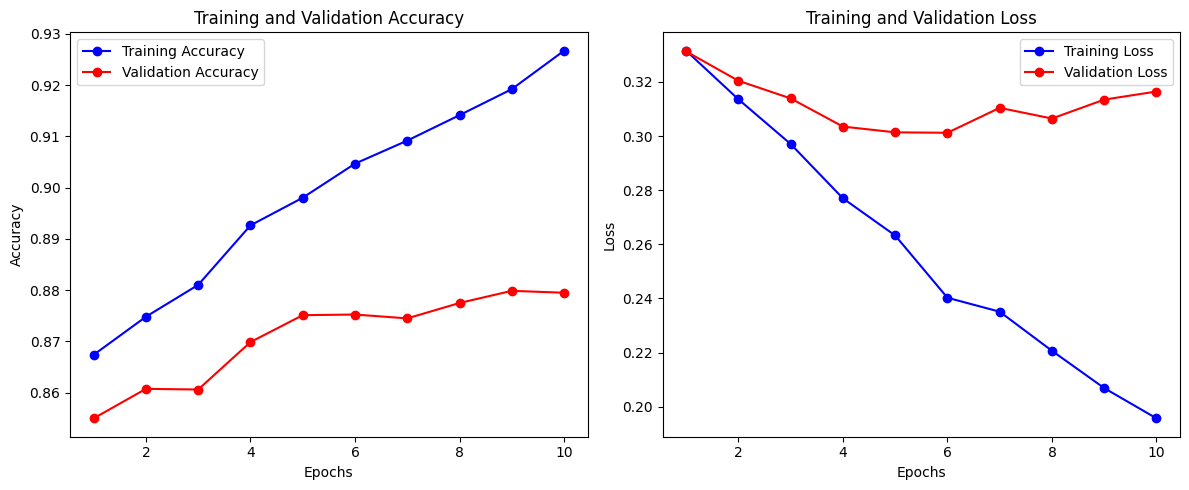

In [60]:
from keras_tuner import HyperParameters

GLOVE_PATH = 'drive/MyDrive/glove.6B.50d.txt'
EMBEDDING_DIM = 50
embedding_index = loadGloveEmbedding(GLOVE_PATH)
embedding_matrix = createEmbeddingMatrix(tokenizer, embedding_index, EMBEDDING_DIM)
vocab_dim = len(tokenizer.word_index) + 1

def build_model_with_glove(hp):
  return build_model(hp, embedding_matrix, EMBEDDING_DIM, vocab_dim)

tuner = RandomSearch(
    build_model_with_glove,
    objective='val_accuracy',
    max_trials=RANDOM_SEARCH_TRY,  # Numero massimo di combinazioni di iperparametri da provare
    directory='drive/MyDrive',  # Directory per salvare i risultati
    project_name='config_1_tune'
)

tuner.search(
    train_reviews, train_labels,
    epochs=RANDOM_SEARCH_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_reviews, val_labels)
)

best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    train_reviews, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_reviews, val_labels)
)

#Valutazione del modello
preds = best_model.predict(test_reviews)
preds = (preds > 0.5).astype(int)
print(evaluateMetrics(test_labels, preds))

#Visualizzazione dei migliori iperparametri
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Migliori iperparametri trovati:")
print(best_hyperparameters.values)
plot_training_history(history)

##Seconda configurazione del modello

Trial 5 Complete [00h 03m 24s]
val_accuracy: 0.8852499723434448

Best val_accuracy So Far: 0.8991249799728394
Total elapsed time: 00h 17m 00s
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


875/875 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.9360 - loss: 0.1665 - val_accuracy: 0.8849 - val_loss: 0.2828
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9321 - loss: 0.1763 - val_accuracy: 0.8934 - val_loss: 0.2934
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9460 - loss: 0.1400 - val_accuracy: 0.8959 - val_loss: 0.3005
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9509 - loss: 0.1305 - val_accuracy: 0.8982 - val_loss: 0.3505
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9520 - loss: 0.1257 - val_accuracy: 0.8926 - val_loss: 0.3052
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9586 - loss: 0.1130 - val_accuracy: 0.8932 - val_loss: 0.3192
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9612 - loss: 0.1019 - val_accuracy: 0.8956 - val_loss: 0.3555
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9645 - loss: 0.0982 - val_accurac

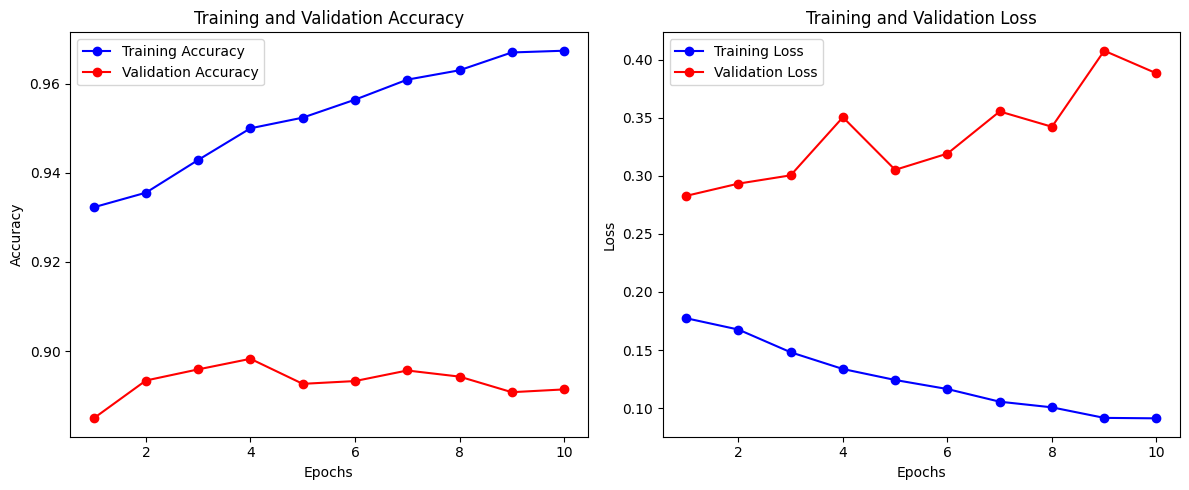

In [61]:
GLOVE_PATH = 'drive/MyDrive/glove.6B.100d.txt'
EMBEDDING_INDEX_PATH = 'drive/MyDrive/embedding_index.pkl'
EMBEDDING_DIM = 100

embedding_index = loadGloveEmbedding(GLOVE_PATH)
embedding_matrix = createEmbeddingMatrix(tokenizer, embedding_index, EMBEDDING_DIM)
vocab_dim = len(tokenizer.word_index) + 1

tuner = RandomSearch(
    build_model_with_glove,
    objective='val_accuracy',
    max_trials=RANDOM_SEARCH_TRY,  # Numero massimo di combinazioni di iperparametri da provare
    directory='drive/MyDrive',  # Directory per salvare i risultati
    project_name='config_2_tune'
)

tuner.search(
    train_reviews, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_reviews, val_labels)
)

best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    train_reviews, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_reviews, val_labels)
)

#Valutazione del modello
preds = best_model.predict(test_reviews)
preds = (preds > 0.5).astype(int)
print(evaluateMetrics(test_labels, preds))

#Visualizzazione dei migliori iperparametri
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Migliori iperparametri trovati:")
print(best_hyperparameters.values)
plot_training_history(history)


#Valutazione dei modelli con recensioni scritte non appartenenti al DS

In quest'ultima fase valuteremo il nostro ultimo modello andando a testarlo su recensioni non appartenenti al dataset

In [69]:
reviews = [
    "Powerful and easy to use. Cleans perfectly. Highly recommend!",
    "Cooks perfectly, easy to clean. Love it!",
    "Fast, great coffee. Worth every penny!",
    "Burns everything. Poor quality. Avoid!",
    "Stopped working after a month. Very disappointed.",
    "Gets stuck constantly. Waste of money."
]

labels = [1,1,1,0,0,0]

my_reviews = tf.constant(reviews)
my_labels = tf.constant(labels)

my_ds = tf.data.Dataset.from_tensor_slices((my_reviews, my_labels))
my_ds = my_ds.batch(1)

my_reviews, my_labels = preprocessDataset(my_ds, remove_stopwords=True)
my_reviews = preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(my_reviews),
    maxlen=MAX_LEN,
    padding="post"
)

preds = best_model.predict(my_reviews)
preds = (preds > 0.5).astype(int)
print(evaluateMetrics(my_labels, preds))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
      Metric  Value
0   Accuracy    1.0
1  Precision    1.0
2     Recall    1.0
3   F1 Score    1.0
